# Validation of the 4x4 scheme with the solitary wave solution using many grids

Libraries and routines necessary for the execution of this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nswe_wbmuscl4 as wb4
def fluxes_periodic(h,hu,n):
    nx = h.shape[0]-4
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)

    h0[3:-3] = h[2:-2]
    u0[3:-3] = hu[2:-2] #hu
    u0 = np.where(h0>1e-10,u0/h0,h0)#hu/h
    
    #periodic bcs
    h0[:3] = h0[-6:-3]
    h0[-3:] = h0[3:6]
    u0[:3] = u0[-6:-3]
    u0[-3:] = u0[3:6]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0,hmin=1e-20)
    return fp

# Case definition

According to Carter and Cienfuegos (2011), the Rayleight solitary wave is defined by 

$$ h(x,t) = a_0 + a_1 sech^2(\kappa(x-ct))$$
$$ u(x,t) = c \left( 1 - \frac{a_0}{h(x,t)} \right) $$

In [3]:
def solitary(x,t,a0,a1):
    kappa = np.sqrt(3.*a1)/(2.*a0*np.sqrt(a0+a1))
    c = np.sqrt(9.81*(a0+a1))
    h = a0 + a1*np.cosh(kappa*(x-c*t))**(-2)
    u = c*(1.-h0/h)
    return kappa,c,h,u

The parameters used are the same as the first configuration used in section 4.1 of the paper of Bonneton et al. 2011.

In [4]:
h0 = 0.5
a = 0.05*h0

# Domain discretization

In [5]:
L = 30.0*4
dx = np.array([1.0,1.0/2.0,1.0/4.0,1.0/8.0])
dx = np.hstack([[L/8,L/16,L/32,L/64],dx])
nx = L/dx+1
ngrids = dx.shape[0]
xmin = -L/2.
xmax = L/2.

In [6]:
x = [np.linspace(-L/2.-2*dx[i],L/2.+2*dx[i],nx[i]+4) for i in range(dx.shape[0])]
print 'grid size:', [ np.diff(x[i])[0] for i in range(ngrids)]
print 'number of cells:', nx

grid size: [15.0, 7.5, 3.75, 1.875, 1.0, 0.5, 0.25, 0.125]
number of cells: [   9.   17.   33.   65.  121.  241.  481.  961.]


# Initial condition

In [7]:
h = []
u = []
for i in range(ngrids):
    kappa,c,hi,ui = solitary(x[i],0.0,h0,a)
    h.append(hi)
    u.append(ui)

Some additional, resulting properties

In [15]:
print "celerity: %3f m/s"%c
print "wave number: %3f rad/m"%kappa

celerity: 2.269416 m/s
wave number: 0.377964 rad/m


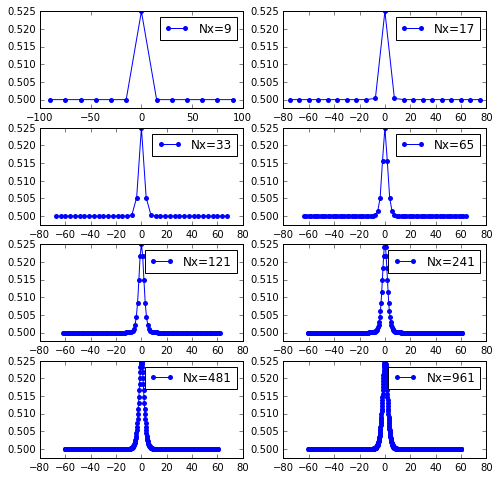

In [16]:
plt.figure(figsize=(8,8))
for i in range(ngrids):
    plt.subplot(ngrids/2,2,i+1)
    plt.plot(x[i],h[i],'o-',label='Nx=%i'%nx[i],mew=0.0,ms=5)
    plt.ylim(h0-0.1*a,h0+a)
    plt.legend(loc=0)

## Simulation time

In [17]:
T = L/2/c*0.8
print T

21.1508138004


## Simulations

In [18]:
import serre

The first time you execute the cell below it will take some time (10min probably). Later it will load the same results from a saved file, not having to do all calculations again

In [26]:
 os.path.isfile(fout)

True

In [27]:
fout = "serreSolitaryNgrids%i.npy"%ngrids
import os.path
if os.path.isfile(fout):
    hut = np.load(fout)
else:
    hut =[serre.splitSerre(x[i],h[i],u[i],
                       0,T,serre.periodicDomainTwoGC,
                     serre.periodicDomain2TwoGC,None,None,dx[i],
                     nx[i],vardt = False, dt = 0.05/2, splitSteps=3,
                     order=2, periodic=True, fvsolver = fluxes_periodic, 
                     fdsolver = serre.EFDSolverFM4, ghostcells=2) for i in range(ngrids)]
    np.save(fout,hut)

The hut list must be used as
    
    hut[ngrid][nvar][nx,nt]
    
Where
    
    hut[ngrid]

picks the solution for one of the grids



is a list of size 3 that contains the solution for grid "ngrid" with numpy arrays h, u and t, each of shapes (nx+4,nt), (nx+4,nt) and (nt,). 

# Animation with a coarse grid


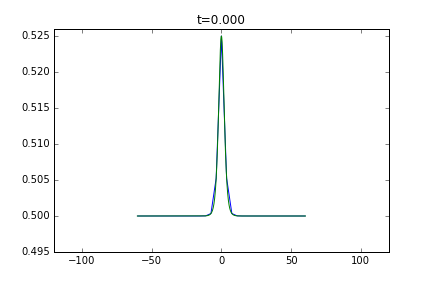
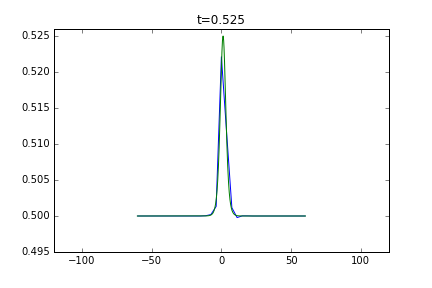
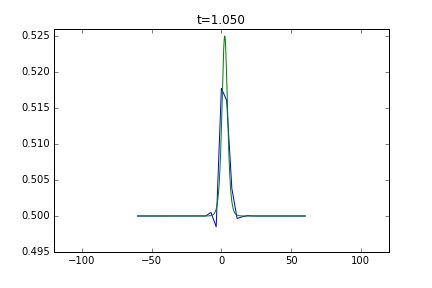
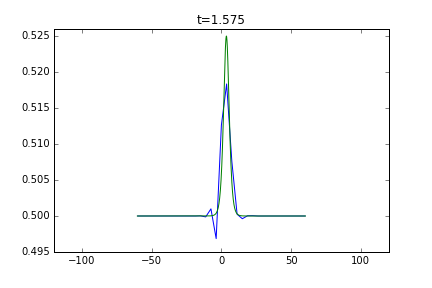
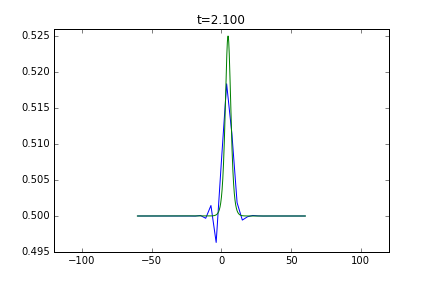
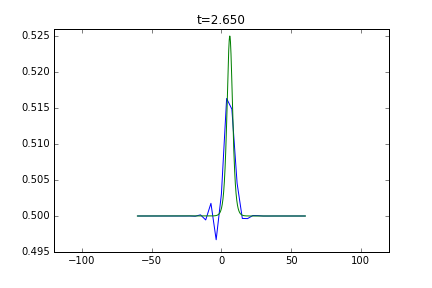
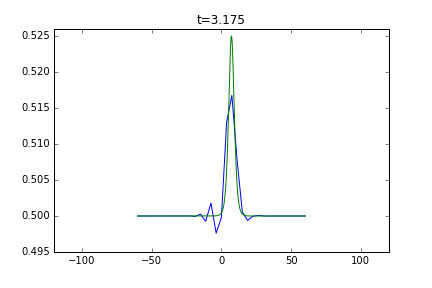
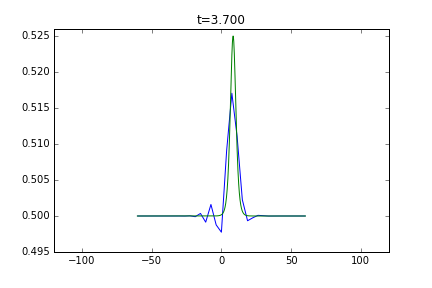
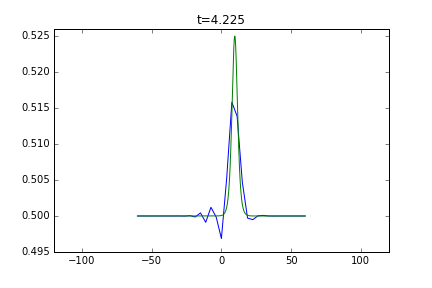
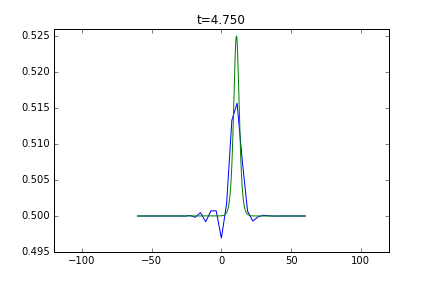
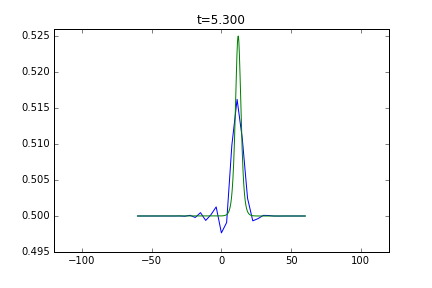
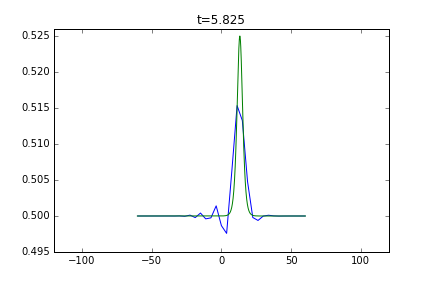
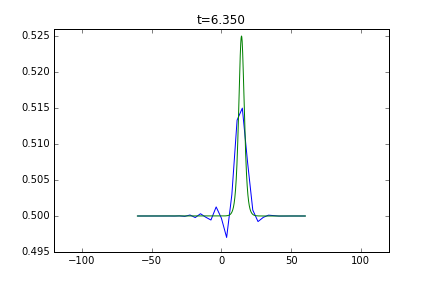
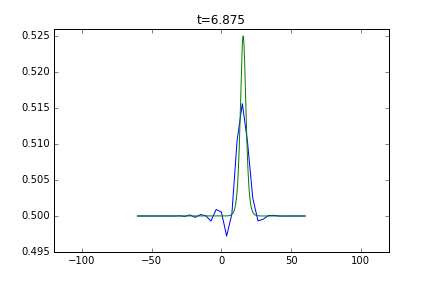
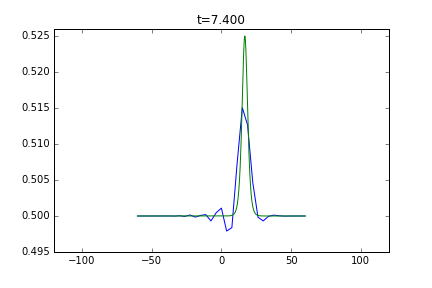
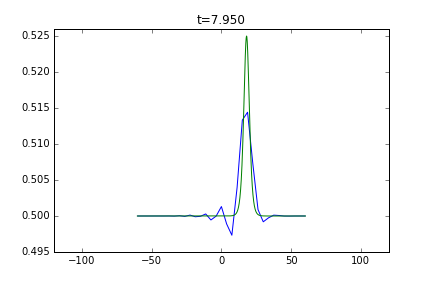
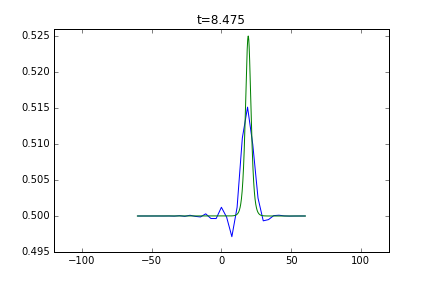
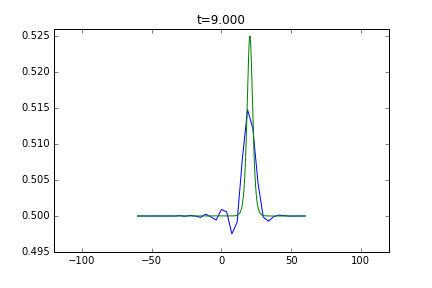
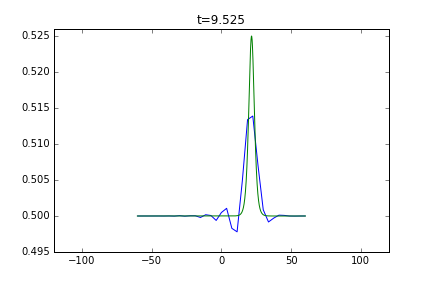
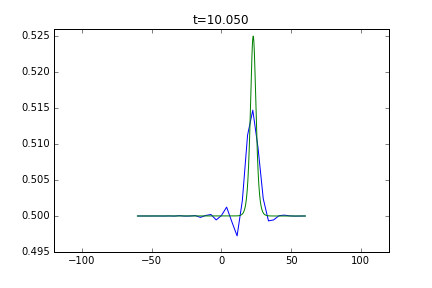
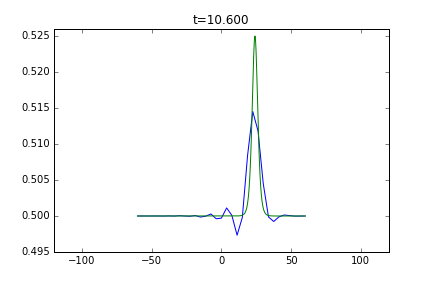
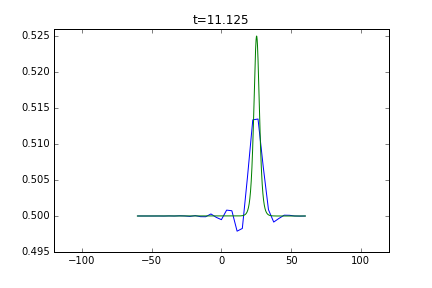
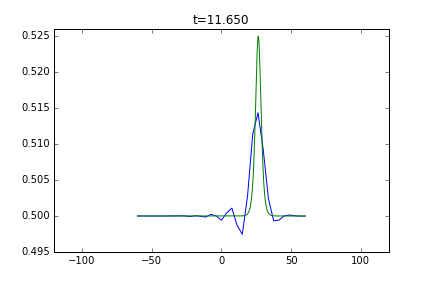
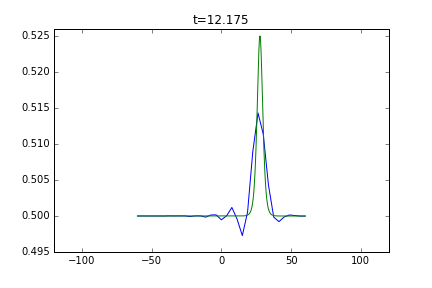
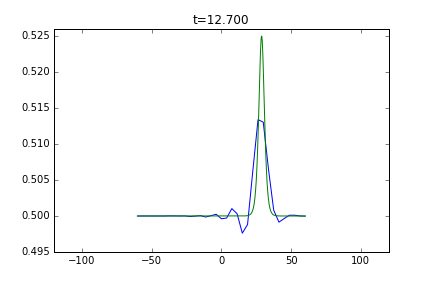
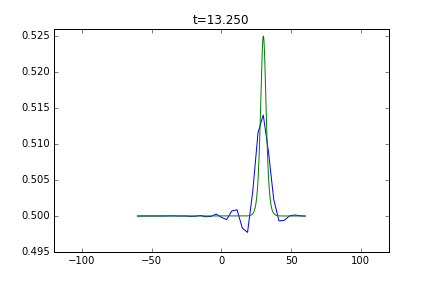
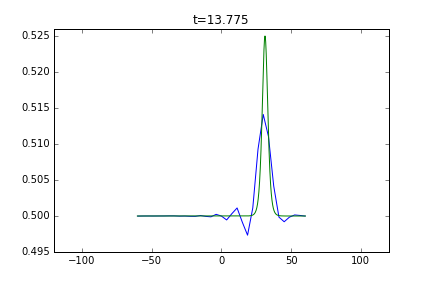
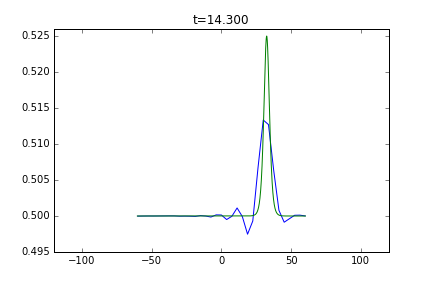
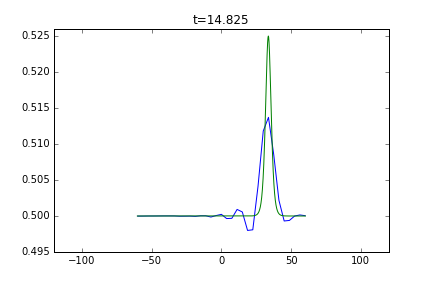
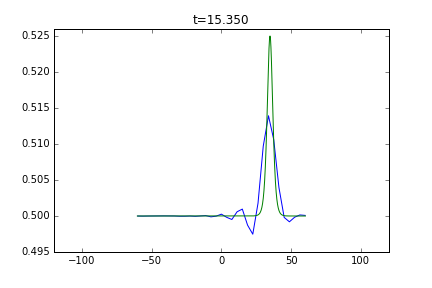
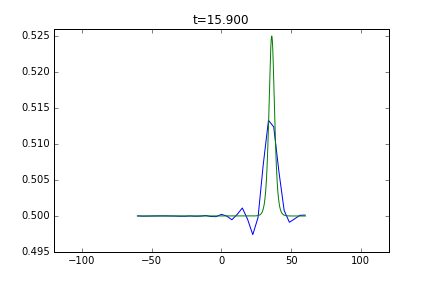
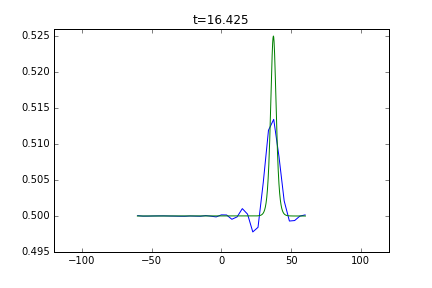
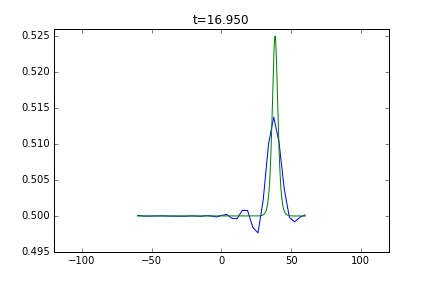
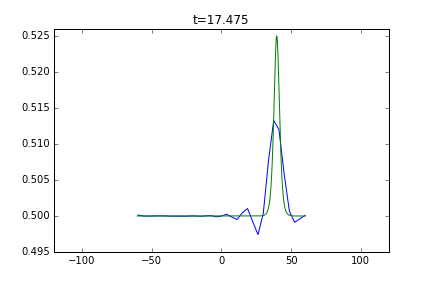
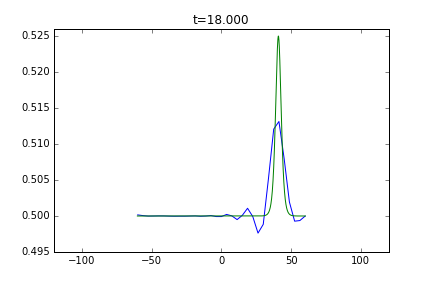
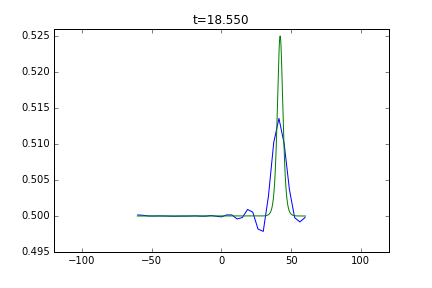
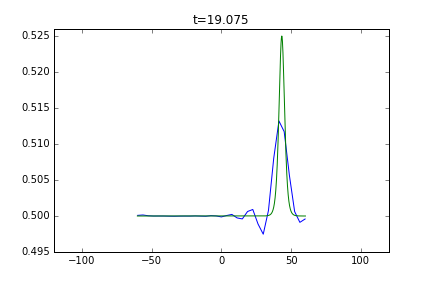
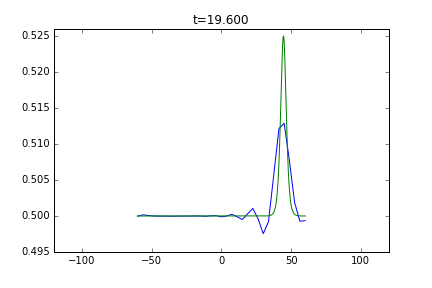
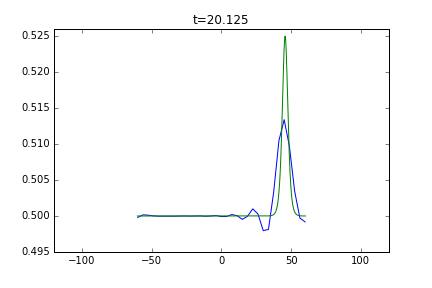
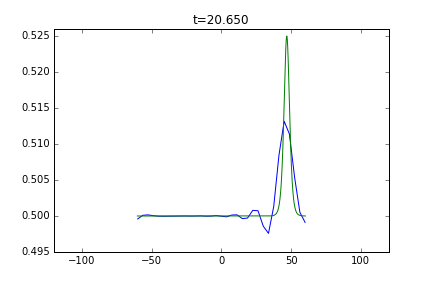

In [57]:
from matplotlib import animation
from JSAnimation import IPython_display

ngrid = 2
fig = plt.figure()
ax = plt.axes(xlim=(-L,L), ylim=(0.495,0.526))
lineSerre4, = ax.plot(x[ngrid][2:-2],hut[ngrid][0][2:-2,0])
kk,cc,ha,ua = solitary(x[-1],0.0,h0,a)
lineExact, = ax.plot(x[-1],ha)


ttl = ax.set_title('t=')
def animate(i):
    h = hut[ngrid][0]
    t = hut[ngrid][2]
    
    i = min(t.shape[0]-1,i*h.shape[1]/40)
    ttl.set_text('t=%.3f'%t[i])
 
    kk,cc,ha,ua = solitary(x[-1],t[i],h0,a)
    
    lineSerre4.set_data(x[ngrid][2:-2],h[2:-2,i])
    lineExact.set_data(x[-1],ha)
    

animation.FuncAnimation(fig, animate, frames=40, interval=200)

We can see the oscillatory and decreasing behavior of the maximum as the wave travels.

# Evolution

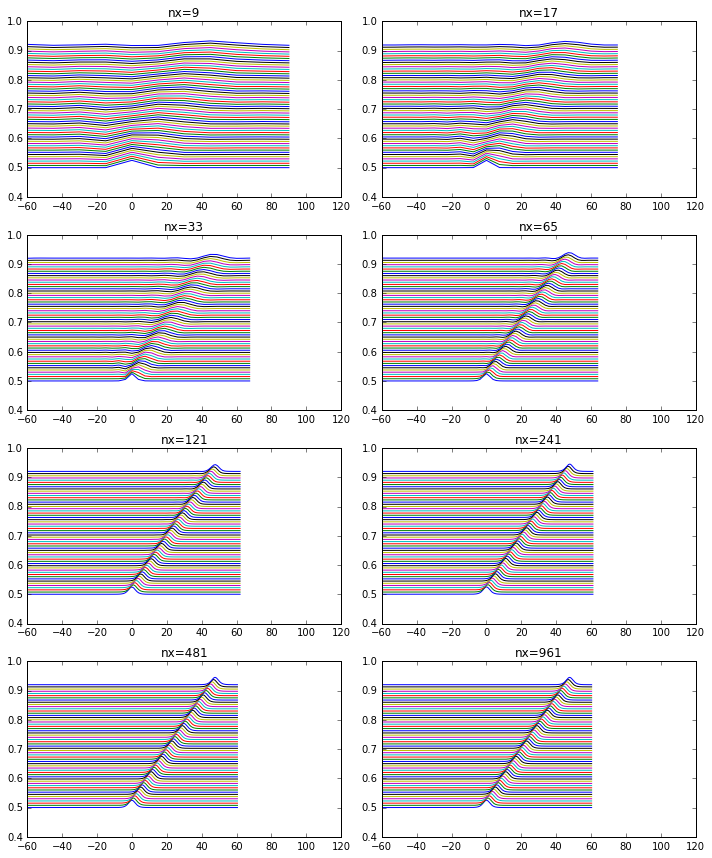

In [58]:
plt.figure(figsize=(10,12))
for ngrid in range(ngrids):
    plt.subplot(ngrids/2,2,ngrid+1)
    
    for n in range(0,hut[ngrid][0].shape[1],15):                
        plt.plot(x[ngrid],hut[ngrid][0][:,n]+0.5*1e-3*n);
    plt.title("nx=%i"%nx[ngrid])
#     plt.axis('off')
    plt.xlim(-L/2,L)
plt.tight_layout()

# Trajectory

Check how many time steps each grid used

In [59]:
nt = [hut[ngrid][2].shape[0] for ngrid in range(ngrids)]
nt

[848, 848, 848, 848, 848, 848, 848, 848]

It is the same for all of them.

Now calculate the location of the maximum at each time step, on each grid

In [60]:
xmax = np.zeros((ngrids,nt[0]))
for ngrid in range(ngrids):
    xmax[ngrid,:] = [x[ngrid][np.argmax(hut[ngrid][0][:,i])] 
            for i in range(hut[ngrid][2].shape[0])]

Plot all the trajectories at once

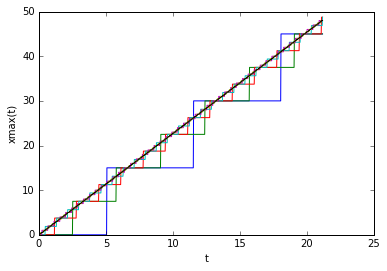

In [61]:
for i in range(ngrid):
    plt.plot(hut[ngrid][2],xmax[i,:],'-')
plt.xlabel('t')
plt.ylabel('xmax(t)')

For coarser grids, when the maximum travels from one cell to the other its location is constant. Also, it is good to remember that the FV solution represents cell averages.

Now to see where they are located physically

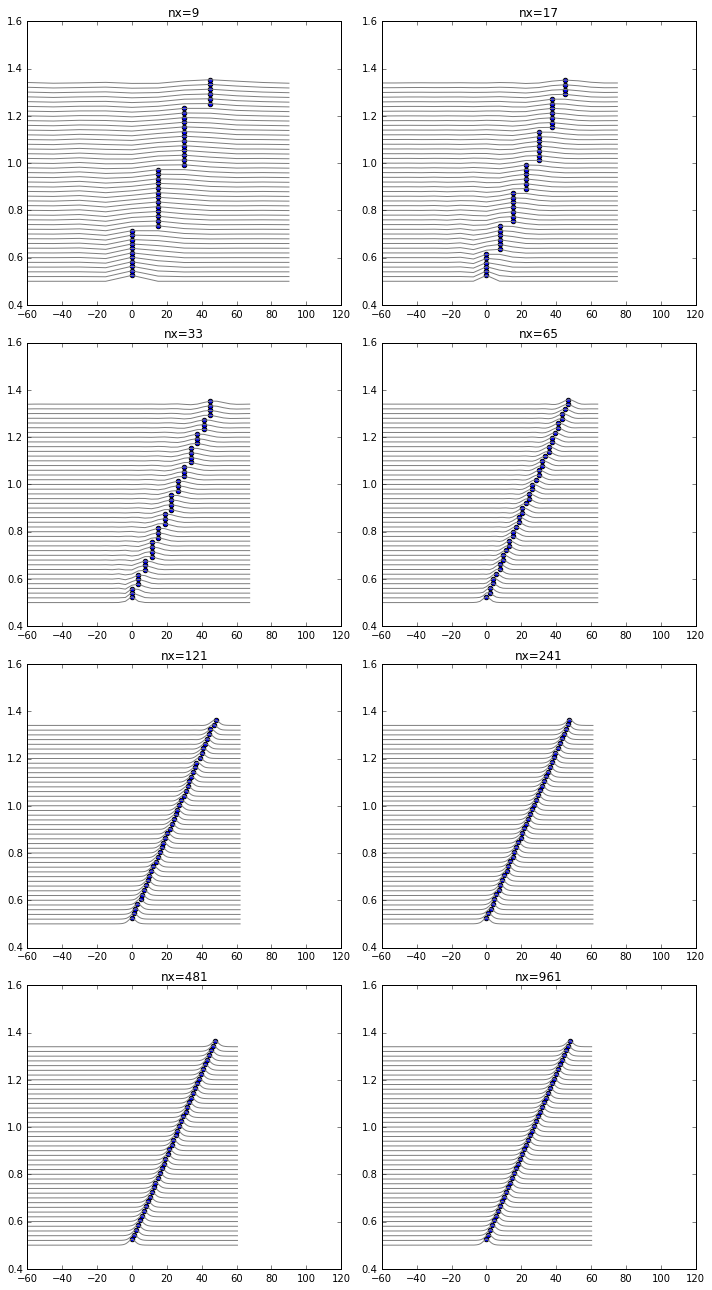

In [62]:
plt.figure(figsize=(10,18))
for ngrid in range(ngrids):
    plt.subplot(ngrids/2,2,ngrid+1)    
    for n in range(0,hut[ngrid][0].shape[1],20):                
        plt.plot(x[ngrid],hut[ngrid][0][:,n]+1e-3*n,color='gray');
        plt.scatter(xmax[ngrid][n],hut[ngrid][0][:,n].max()+1e-3*n)
#     plt.plot(xmax[ngrid],0.5+np.linspace(0,0.5*1e3*xmax.shape[1],xmax.shape[1]))
    plt.title("nx=%i"%nx[ngrid])
#     plt.axis('off')
    plt.xlim(-L/2,L)
plt.tight_layout()

It looks really well at the finest grids. Now I compare the difference with the exact trajectory

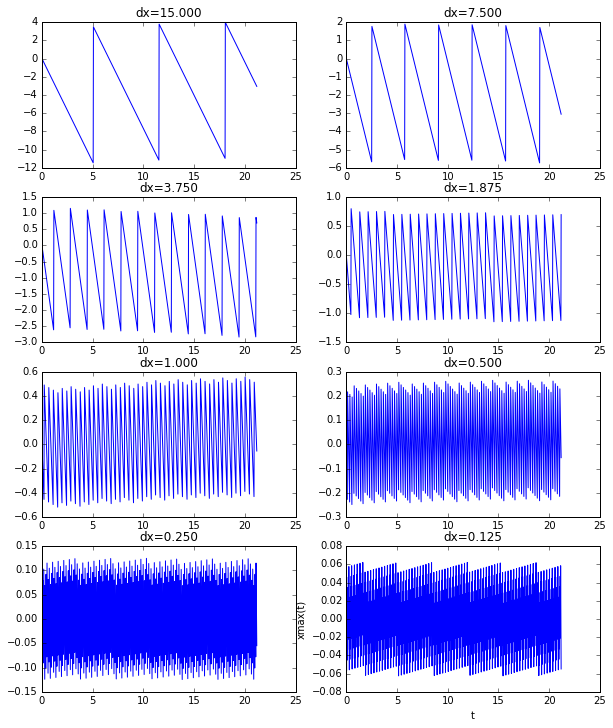

In [65]:
plt.figure(figsize=(10,12))
for ngrid in range(ngrids):
    plt.subplot(ngrids/2,2,ngrid+1)
    plt.plot(hut[ngrid][2],xmax[ngrid]-hut[ngrid][2]*c,'-')
#     plt.ylim(-12,4)
    plt.title('dx=%.3f'%dx[ngrid])
plt.xlabel('t')
plt.ylabel('xmax(t)')

It verifies the hypothesis that the error is of $O(\Delta x)$

I can compute the range of variation as a function of $\Delta x$ as 
$$ \max_{t\in[0,T]}(x_{max}(t)-ct) - \min_{t\in[0,T]}(x_{max}(t) - ct) $$


In [75]:
xVariationRange = np.zeros(ngrids)
for ngrid in range(ngrids):
    xvar = xmax[ngrid]-hut[ngrid][2]*c
    xVariationRange[ngrid] = xvar.max()-xvar.min()

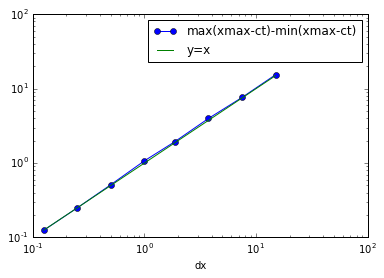

In [98]:
plt.loglog(dx,xVariationRange,'o-',label='max(xmax-ct)-min(xmax-ct)')
plt.loglog(dx,dx,label='y=x')
plt.legend(loc=0)
plt.xlabel('dx')

It clearly is $O(\Delta x)$

I could also plot the maximum difference in the trajectory for each grid, as

$$ max diff = || xmax(t) - ct||_{\infty} = \max_{t\in[0,T]}|x_{max}(t)-ct|$$

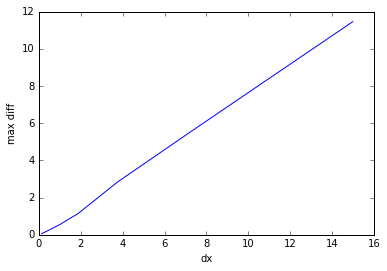

In [95]:
maxdiffTrajectory = np.array([
np.abs(xmax[ngrid]-hut[ngrid][2]*c).max() for ngrid in range(ngrids)])
plt.plot(dx,maxdiffTrajectory)
plt.ylabel('max diff')
plt.xlabel('dx')

# Max amplitude decay

In [99]:
hmax = np.zeros((ngrids,nt[0]))
for ngrid in range(ngrids):
    hmax[ngrid,:] = [np.max(hut[ngrid][0][:,i])
            for i in range(hut[ngrid][2].shape[0])]

In [100]:
plt.figure()
plt.gcf().get_size_inches()

array([ 6.,  4.])

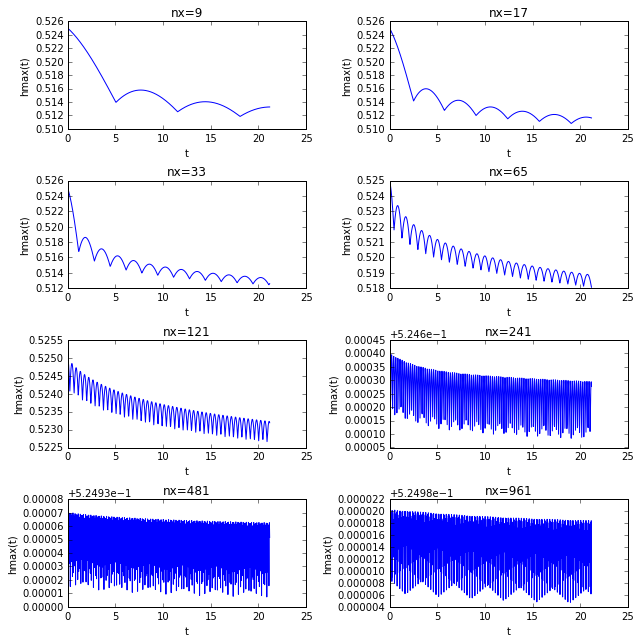

In [101]:
plt.figure(figsize=(9,9))

for ngrid in range(ngrids):
    plt.subplot(ngrids/2,2,ngrid+1)
    plt.plot(hut[ngrid][2],hmax[ngrid],'-')
    plt.xlabel('t')
    plt.ylabel('hmax(t)')
#     plt.ylim(h0+0.4*a,h0+1.01*a)
    plt.title('nx=%i'%nx[ngrid])
plt.tight_layout()


$  H(t)=h(t)-h_0 = a-e^{-k_{grid}t}$

** Discuss formula with Rodrigo**

** PUT AN ANIMATION HERE WITH A COARSE GRID TO SEE THE BUMPY BEHAVIOR**

# Convergence

Initialize error array

In [102]:
Eh = np.zeros((ngrids,nt[0]))
Eu = np.zeros((ngrids,nt[0]))

Calculate the normalized squared error

$$ E_h(t) = \frac{||h_{num}(t)-h_{sol}(t)||}{||h_{sol}(t)-h_0||}$$
$$ E_u(t) = \frac{||u_{num}(t)-u_{sol}(t)||}{||u_{sol}(t)||}$$

But, from the experiment we see some interaction with the boundary, so the error is computed for $t\in[0,15]$ only.

In [112]:
sim =0
for sim in range(ngrids):
    Dx = dx[sim]
    h = hut[sim][0]
    u = hut[sim][1]
    t = hut[sim][2]
    
    iTfinal = np.where(t>=15)[0][0]
    
    #error for each timestep
    for i in range(iTfinal):
        kk,cc,ha,ua = solitary(x[sim],hut[sim][2][i],h0,a)
        Eh[sim,i] = np.sum((h[2:-2,i]-ha[2:-2])**2*Dx)
        Eh[sim,i] = Eh[sim,i]/np.sum((ha[2:-2]-h0)**2*Dx)
        Eh[sim,i] = np.sqrt(Eh[sim,i])
        
        Eu[sim,i] = np.sum((u[2:-2,i]-ua[2:-2])**2*Dx)
        Eu[sim,i] = Eu[sim,i]/np.sum(ua[2:-2]**2*Dx)
        Eu[sim,i] = np.sqrt(Eu[sim,i])

Plots for $h$

In [113]:
ha[-10:]-0.5

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [114]:
hut[sim][2][700]

17.500000000000075

Since the timestep is constant the time index for $T=15s$ is the same for all simulations. I can "recycle" the "iTfinal" variable.

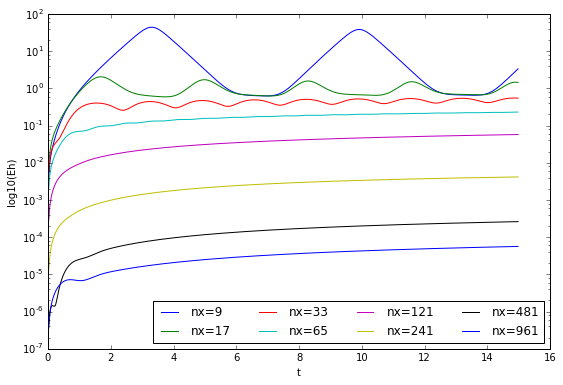

In [118]:
plt.figure(figsize=(9,6))
for sim in range(ngrids):
    plt.semilogy(hut[sim][2][1:iTfinal],(Eh[sim,1:iTfinal]),label="nx=%i"%nx[sim])
plt.legend(loc=0,ncol=4)
plt.xlabel('t')
plt.ylabel('log10(Eh)')

Plot the maximum error as a function of the grid size

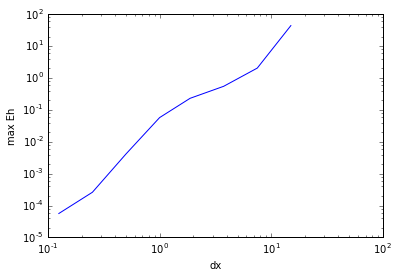

In [119]:
maxEh = np.array([Eh[sim,:iTfinal].max() for sim in range(ngrids)])
plt.loglog(dx,maxEh)
plt.xlabel('dx')
plt.ylabel('max Eh')

The same for the velocity field

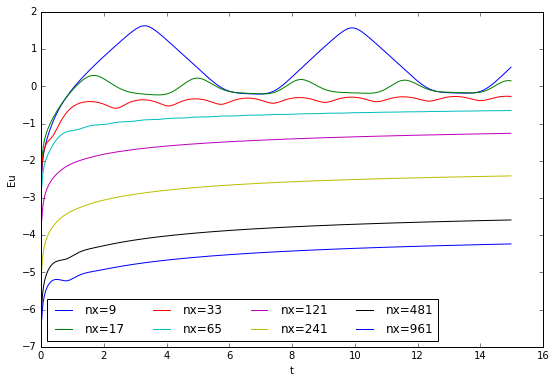

In [123]:
plt.figure(figsize=(9,6))
for sim in range(ngrids):
    plt.plot(hut[sim][2][1:iTfinal],np.log10(Eu[sim,1:iTfinal]),label="nx=%i"%nx[sim])
plt.legend(loc=0,ncol=4)
plt.xlabel('t')
plt.ylabel('Eu')

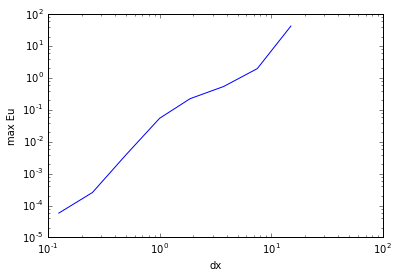

In [124]:
maxEu = np.array([Eu[sim,:iTfinal].max() for sim in range(ngrids)])
plt.loglog(dx,maxEu)
plt.xlabel('dx')
plt.ylabel('max Eu')